# Sorghum Shape and Morphology Analysis

This is a full workflow that shows methods for analyzing shape, color, and morphological features of plants imaged from a side-view. Similar methods should work for other tyles of plants that are imaged in a similar way.

# Section 1: Importing libraries and image

In [82]:
# Set the notebook display method
# inline = embedded plots, notebook = interactive plots
%matplotlib inline

In [83]:
# Import libraries
from plantcv import plantcv as pcv 

## Input variables

The options class mimics the workflow command-line argument parser that is used for workflow parallelization. Using it while developing a workflow in Jupyter makes it easier to convert the workflow to a script later.

In [84]:
class options:
    def __init__(self):
        self.image = "./img/side_view_sorghum.png"
        self.debug = "plot"
        self.writeimg= False 
        self.result = "side_view_morphology_analysis.txt"
        self.outdir = "."

In [85]:
# Get options
args = options()

# Set debug to the global parameter
pcv.params.debug = args.debug

# Set plotting size (default = 100)
pcv.params.dpi = 100

# Increase text size and thickness to make labels clearer
# (size may need to be altered based on original image size)
pcv.params.text_size = 2
pcv.params.text_thickness = 2
pcv.params.line_thickness = 10

## Read the input image

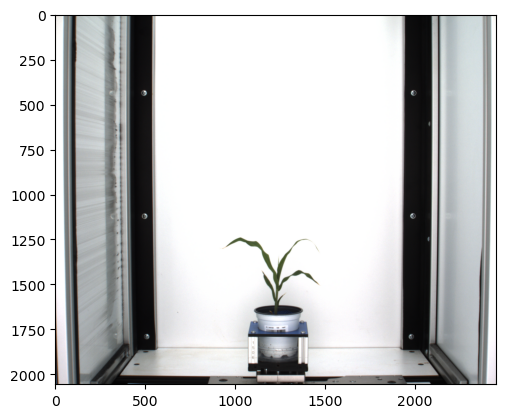

In [86]:
# Inputs:
#   filename - Image file to be read in 
#   mode - How to read in the image; either 'native' (default), 'rgb', 'gray', or 'csv'
img, path, filename = pcv.readimage(filename=args.image)

# Section 2: Isolating plant, making binary mask, getting object(s)
* Requires successful import of image
* See Tools for Thresholding Plant Material for a full list of functions  that can be used to create a binary mask

## Visualize colorspaces

The visualization tool converts the color image into HSV and LAB colorspaces and displays the grayscale channels in a matrix so that they can be visualized simultaneously. The idea is to select a channel that maximizes the difference between the plant and the background pixels.

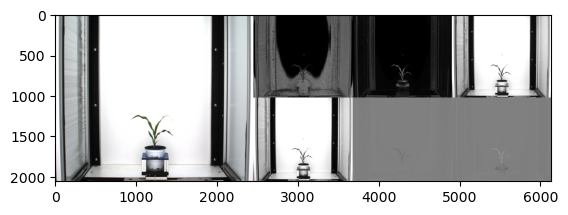

In [87]:
# Inputs:
#   rbg_img      = original image
#   original_img = whether to include the original RGB images in the display: True (default) or False
colorspaces = pcv.visualize.colorspaces(rgb_img=img)

## Convert the color image to grayscale

Converts the input color image into the LAB colorspace and returns the B (blue-yellow) channel as a grayscale image.

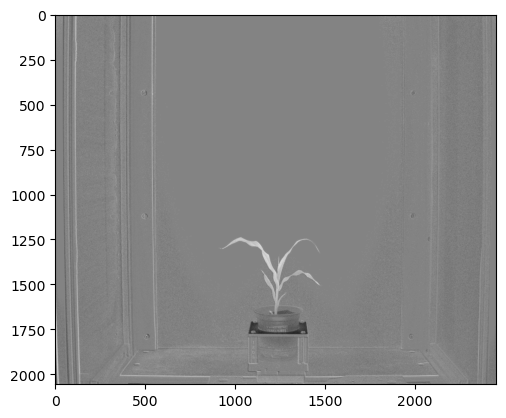

In [88]:
# Inputs:
#   rbg_img - original image
#   channel - desired colorspace ('l', 'a', or 'b')
a = pcv.rgb2gray_lab(rgb_img=img, channel="b")

## Visualize the distribution of grayscale values

A histogram can be used to visualize the distribution of values in an image. The histogram can aid in the selection of a threshold value.

For this image, the large peak between 120-130 are from the darker background pixels. The smaller peaks that represent plant material cannot be distinguished because there are so few total plant pixels, but we can use the upper bound of the background peaks to estimate a good thresholding point, somewhere between 127-135.

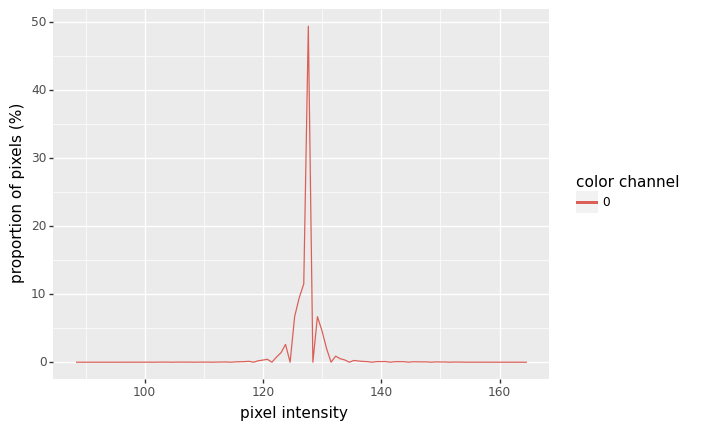

In [89]:
# Inputs:
#   img         = gray image in selected colorspace
#   mask        = None (default), or mask
#   bins        = 100 (default) or number of desired number of evenly spaced bins
#   lower-bound = None (default) or minimum value on x-axis
#   upper-bound = None (default) or maximum value on x-axis
#   title       = None (default) or custom plot title
#   hist_data   = False (default) or True (if frequency distribution data is desired)
hist = pcv.visualize.histogram(img=a)

## Threshold the grayscale image

Use a threshold function (binary in this case) to segment the grayscale image into plant (white) and background (black) pixels. Using the histogram above, a threshold point between 120-125 will segment the plant and background peaks. Because the plant has darker pixels in this image, use object_type="dark" to do a traditional threshold.

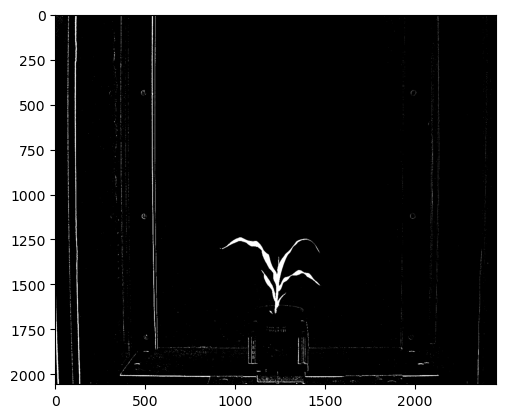

In [90]:
a_thresh = pcv.threshold.binary(gray_img = a, threshold = 134, max_value = 255, object_type = 'light')

## Identify objects within a region of interest (ROI)
To eventually combine all of the objects into a singular object that identifies the plant, we need to identify a region of interest (ROI) which will either fully encapsulate or overlap with plant material. This way, if objects are identified due to "salt" noise or other background elements, they will be filtered out. In this case, a rectangular ROI that partially overlaps with the plant object can be used to filter out some of the excess noise around the plant.

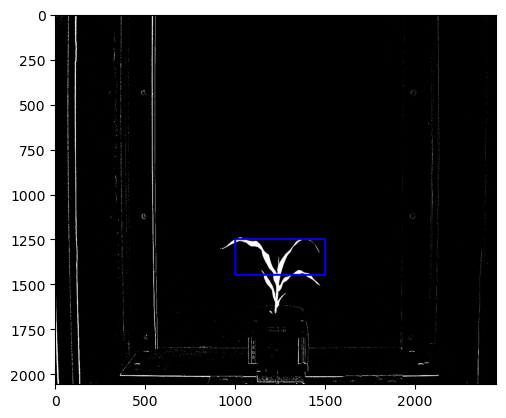

In [91]:
# Inputs:
#   img = image
#   x   = leftmost x coordinate of ROI
#   y   = topmost y coordinate of ROI
#   h   = height of ROI
#   w   = width of ROI
roi1 = pcv.roi.rectangle(img=a_thresh, x=1000, y=1250, h=200, w=500)

## Filter out objects that don't overlap with the ROI
Any objects that do not overlap with the ROI will be filtered out, leaving only objects that identify plant material.

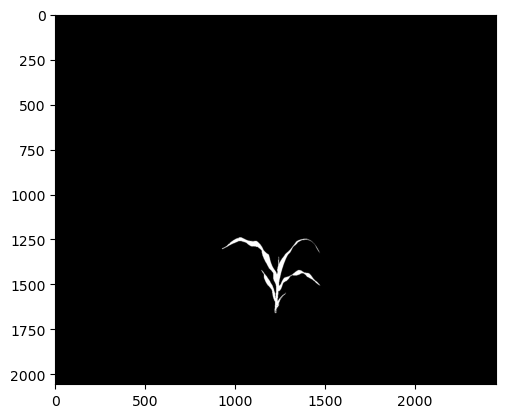

In [92]:
# Inputs:
#   img            = image
#   roi_type       = 'partial' to include objects that partially overlap with the ROI, 'cutto' to exclude any objects that 
#                     are not within the ROI, or 'largest' to keep the largest contour
#   roi_contour    = pre-defined region of interest
#   roi_hierarchy  = pre-defined roi hierarchy
#   object_contour = plant object
#   obj_hierarchy  = object hierarchy
kept_mask = pcv.roi.filter(mask = a_thresh, roi = roi1, roi_type='partial')

## Crop the mask

This is entirely optional, but it can help to look closer at the mask to ensure there is no "salt" noise or any other issues with the binary mask that aren't clear. To visualize the cropped mask, use plot_image.

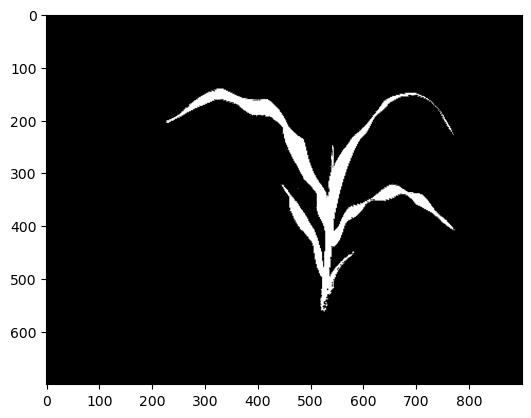

In [93]:
cropped_mask = kept_mask[1100:1800, 700:1600]
cropped_img = img[1100:1800, 700:1600]
pcv.plot_image(cropped_mask)

## Dilate white pixels to preserve plant material

Especially in images with thin leaves, there is a greater risk that when removing 'salt' background noise, some of the plant pixels will be degraded as well. This can be avoided by dilating the image, which increases white pixel area i times. 

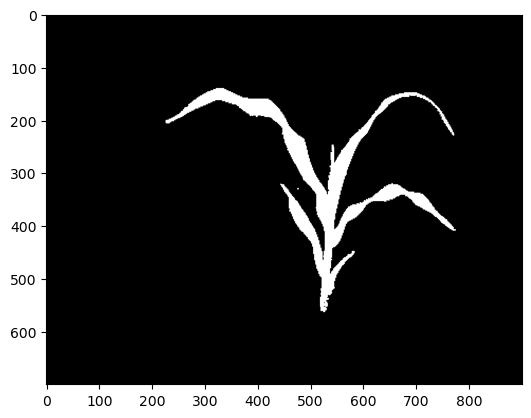

In [94]:
# Inputs:
#   gray_img = gray image data or threshold image data
#   ksize    = an odd integer that is used to build a ksize x ksize matrix using np.ones. 
#              Must be greater than 1 to have an effect.
#   i        = an integer for number of iterations, i.e. the number of consecutive filtering passes.
mask_dilated = pcv.dilate(gray_img = cropped_mask, ksize = 3, i = 1)
# pcv.plot_image(mask_dilated)

## Remove small background noise¶
Thresholding mostly labeled plant pixels white but also labeled small regions of the background white. The fill function removes "salt" noise from the background by filtering white regions by size. After dilating, we can see a few specks of noise that would otherwise interfere with the morphology analysis functions.

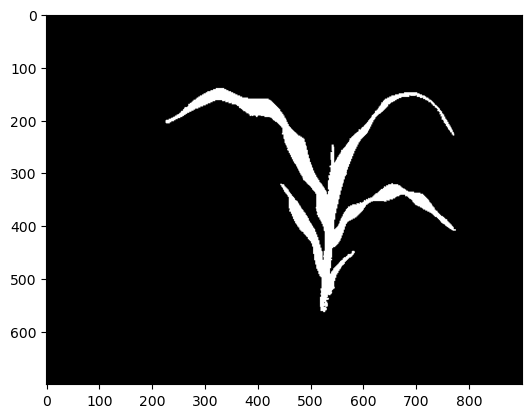

In [95]:
# Inputs:
#   bin_img - binary mask image
#   size - maximum size for objects that should be filled in as background (non-plant) pixels
mask_fill = pcv.fill(bin_img = mask_dilated, size = 30)
# pcv.plot_image(mask_fill)

# Section 3: Morphology analysis

* Requires plant image and completed binary mask

## Skeletonize the mask

Convert the mask into a 1-pixel wide skeleton, which can be used for mophology analyses.

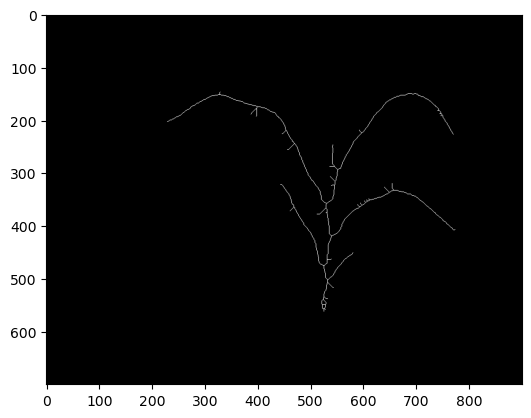

In [96]:
# Inputs:
#   mask = binary mask
skeleton = pcv.morphology.skeletonize(mask=mask_fill)

# Prune the skeleton

Generall, skeletonized images will have barbs that represent the width of plant material, which then need to be pruned off.

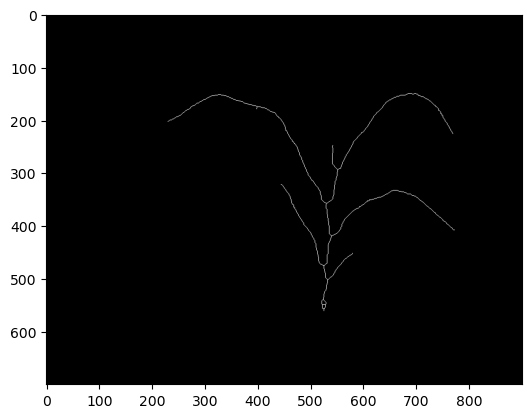

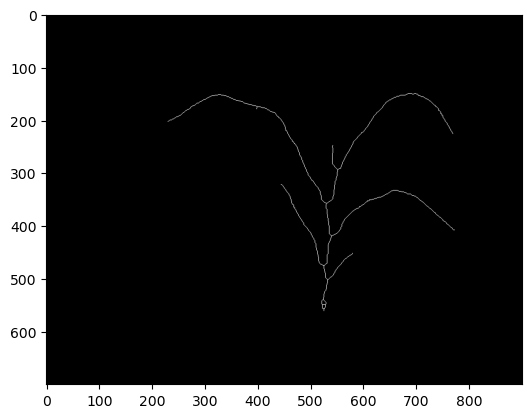

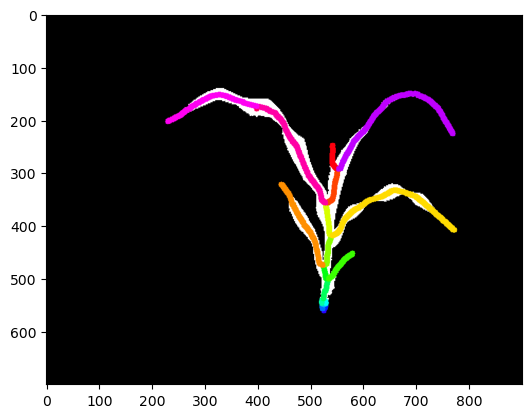

In [97]:
# Inputs:
#   skel_img = Skeletonized image
#   size     = Size to get pruned off each branch
#   mask     = (Optional) binary mask for debugging. If provided, debug image will be overlaid on the mask.
pruned_skel, seg_img, edge_objects = pcv.morphology.prune(skel_img=skeleton, size=50, mask=mask_fill)

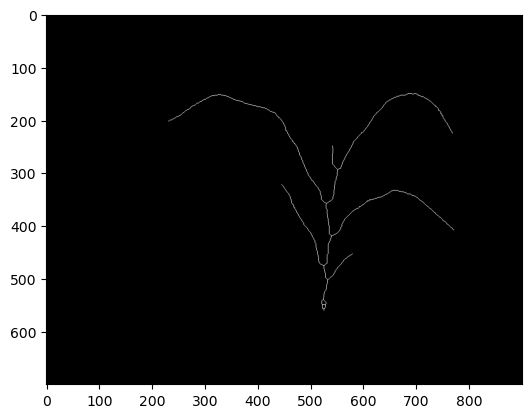

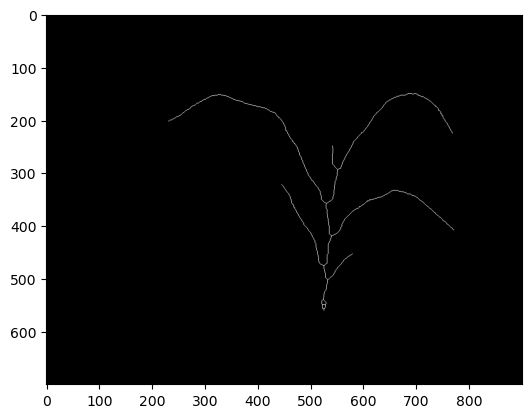

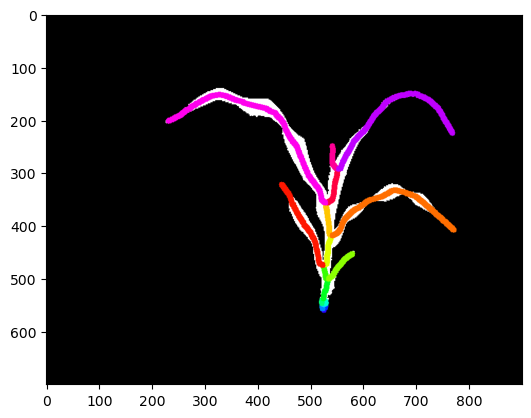

In [98]:
pruned_skel, seg_img, edge_objects = pcv.morphology.prune(skel_img=pruned_skel, size=10, mask=mask_fill)

## Sort segments into stem and leaves

Differentiate between the primary segment (stem) and secondart segments (leaves). Downstream steps can be performed on just one class of objects at a time, or all objects.

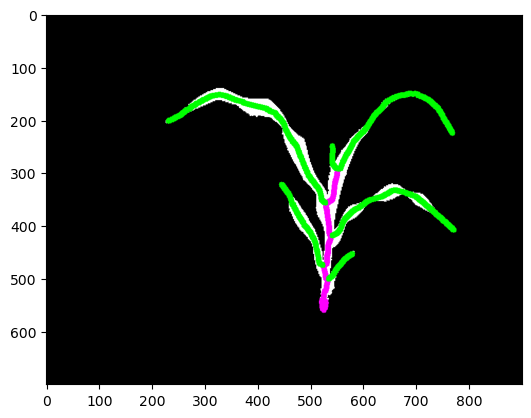

In [99]:
leaf_obj, stem_obj= pcv.morphology.segment_sort(skel_img=pruned_skel, objects = edge_objects, mask=mask_fill)


## Fill in segments

Fill in different segments (branches/leaves) of the plant in the binary mask, and store out area data for each segment.

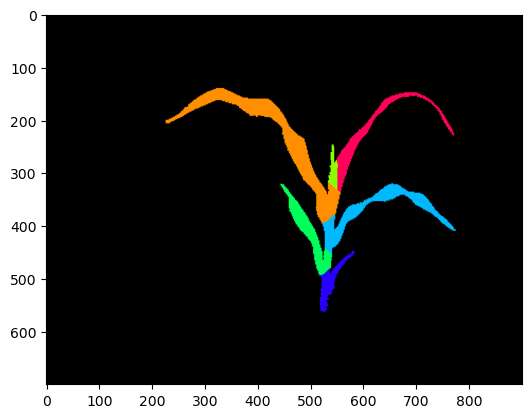

In [100]:
# Inputs:
#   mask    = Binary image, single channel, object = 1 and background = 0
#   objects = List of contours
#   label   = Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)
filled_img = pcv.morphology.fill_segments(mask=mask_fill, objects=leaf_obj, label="default")

## Identify branch points

Find branch/junction points from a skeleton image.

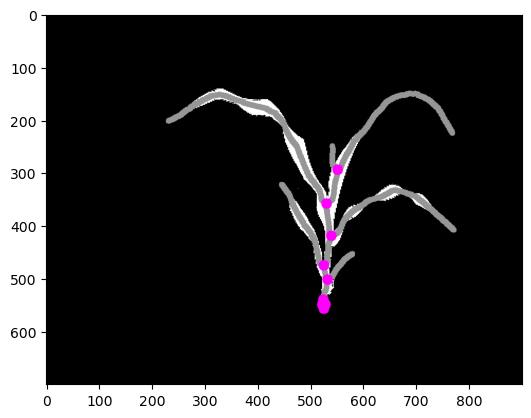

In [101]:
# Inputs:
#   skel_img = Skeletonized image
#   mask     = (Optional) binary mask for debugging. If provided, debug image will be overlaid on the mask.
#   label    = Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)
branch_pts_mask = pcv.morphology.find_branch_pts(skel_img=pruned_skel, mask=cropped_mask, label="default")

## Identify tip points

Find the tip points for branches.

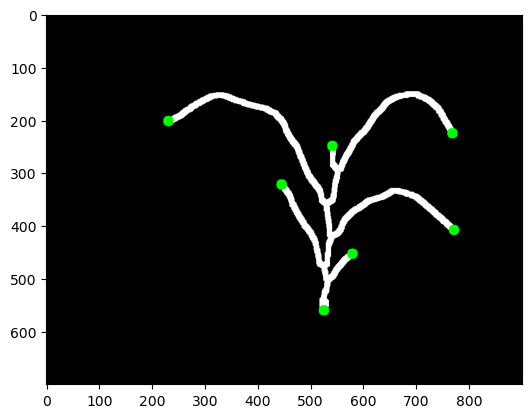

In [102]:
# Inputs:
#   skel_img = Skeletonized image
#   mask     = (Optional) binary mask for debugging. If provided, debug 
#              image will be overlaid on the mask
#   label    = Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)

tip_pts_mask = pcv.morphology.find_tips(skel_img=pruned_skel, mask=None, label="default")

## Identify segments

Identify and label unique segments from skeletonized image.

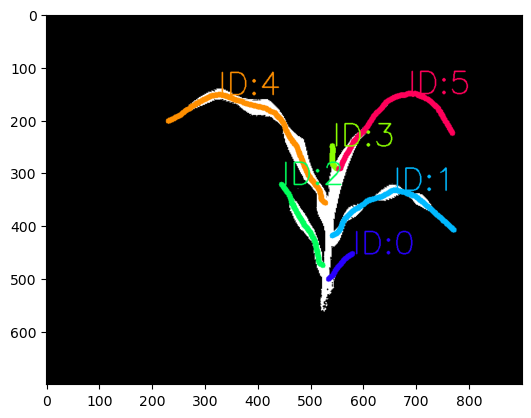

In [103]:
# Inputs:
#   skel_img  = Skeletonized image
#   objects   = List of contours
#   mask      = (Optional) binary mask for debugging. If provided, 
#               debug image will be overlaid on the mask.
segmented_img, labeled_img = pcv.morphology.segment_id(skel_img=pruned_skel,
                                                       objects=leaf_obj,
                                                       mask=cropped_mask)

# Measure length of segments

Measure and plot the path length of each segment.

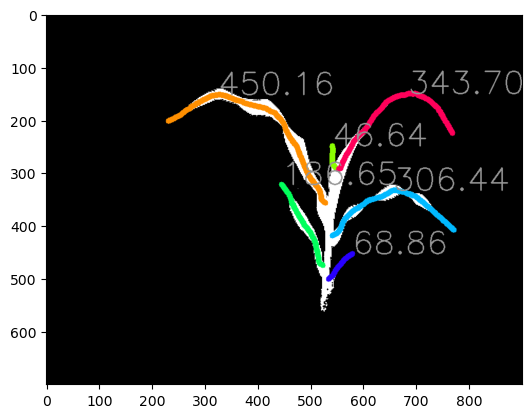

In [104]:
# Inputs:
#   segmented_img = Segmented image to plot lengths on
#   objects       = List of contours
#   label         = Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)
labeled_img  = pcv.morphology.segment_path_length(segmented_img=segmented_img, 
                                                  objects=leaf_obj, label="default")



## Measure euclidean distance of segments

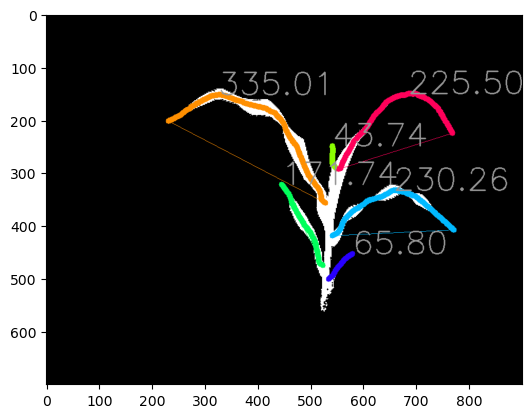

In [105]:
# Inputs:
#   segmented_img = Segmented image to plot lengths on
#   objects       = List of contours
#   label         = Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)
labeled_img = pcv.morphology.segment_euclidean_length(segmented_img=segmented_img, 
                                                      objects=leaf_obj, label="default")

## Measure curvature of segments

Measure segment curvature using the ratio of geodesic distance to euclidean distance. Larger values indicate greater curvature.

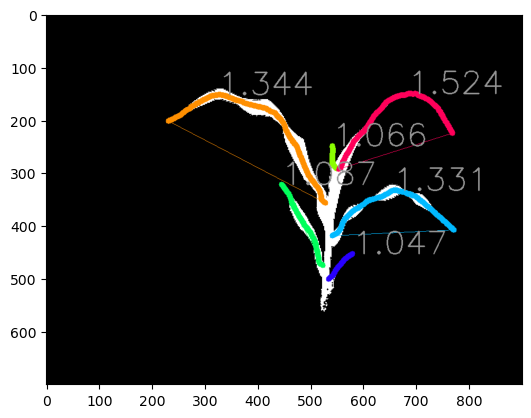

In [106]:
# Inputs:
#   segmented_img = Segmented image to plot curvature on
#   objects       = List of contours
#   label         = Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)
labeled_img = pcv.morphology.segment_curvature(segmented_img=segmented_img, 
                                               objects=leaf_obj, label="default")

## Measure segment angle

Calculate segment angle using a linear regression line fit to each segment, and finding the angle in degrees for each.

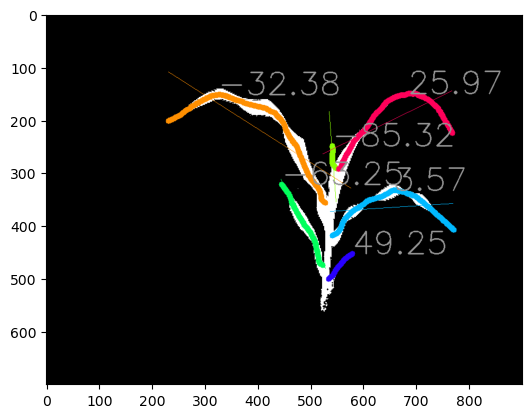

In [107]:
# Inputs:
#   segmented_img = Segmented image to plot angles on
#   objects       = List of contours
#   label         = Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)
#                   filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)
labeled_img = pcv.morphology.segment_angle(segmented_img=segmented_img, 
                                           objects=leaf_obj, label="default")

## Measure tangent angle of segments

Find tangent angles of skeleton segments and calculate angle between the two angles for each segment.

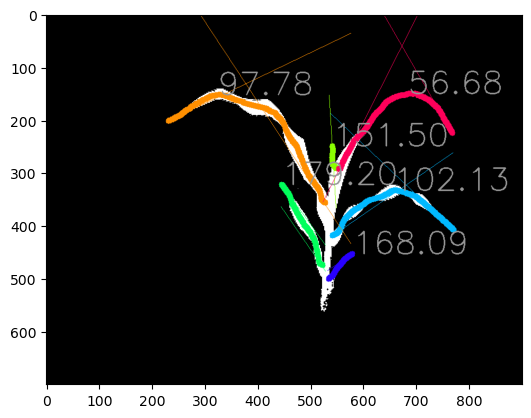

In [108]:
# Inputs:
#   segmented_img = Segmented image to plot tangent angles on
#   objects       = List of contours
#   size          = Size of ends used to calculate "tangent" lines
#   label         = Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)
labeled_img = pcv.morphology.segment_tangent_angle(segmented_img=segmented_img, 
                                                   objects=leaf_obj, size=15, label="default")

## Measure leaf insertion angle

Calculate angle of leaf insertion in segrees compared to stem angle.

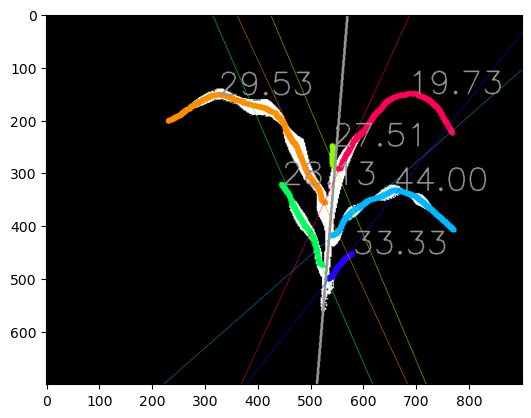

In [109]:
# Inputs:
#   skel_img         = Skeletonize image 
#   segmented_img    = Segmented image to plot insertion angles on
#   leaf_objects     = List of leaf contours
#   stem_objects     = List of stem objects 
#   size             = Size of the inner portion of each leaf to find a linear regression line
#   label            = Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)

labeled_img = pcv.morphology.segment_insertion_angle(skel_img=pruned_skel,
                                                     segmented_img=segmented_img, 
                                                     leaf_objects=leaf_obj, 
                                                     stem_objects=stem_obj,
                                                     size=20, label="default")

## Analyze plant shape

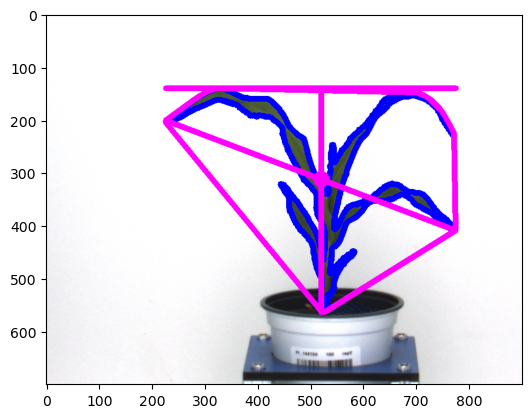

In [110]:
# Inputs:
#   img - RGB or grayscale image data 
#   obj- Single or grouped contour object
#   mask - Binary image mask to use as mask for moments analysis  
#   label - Optional label parameter, modifies the variable name of observations recorded   
shape_img = pcv.analyze.size(img=cropped_img, labeled_mask=mask_fill, label="default")

# Save results

The save results function will take the measurements stored when running any PlantCV analysis functions, format, 
and print an output text file for data analysis. The Outputs class in this example will store: 'segment_area', 'tips', 'branch_pts', 'segment_angle', 'segment_curvature', 'segment_eu_length', 'segment_insertion_angle', 'segment_path_length', and 'segment_tangent_angle' from the morphology functions. Additionally, 'area', 'convex_hull_area', 'solidity', 'perimeter', 'width', 'height', 'longest_path', 'center_of_mass, 'convex_hull_vertices', 'object_in_frame', 'ellipse_center', 'ellipse_major_axis', 'ellipse_minor_axis', 'ellipse_angle', and 'ellipse_eccentricity' are stored from the anayze_object function.

Here, results are saved to a CSV file for easy viewing, but when running workflows in parallel, save results as "json"

In [111]:
# Inputs:
#   filename  = filename for saving results
#   outformat = output file format: "json" (default) hierarchical format or "csv" tabular format
pcv.outputs.save_results(filename=args.result)